## Import Library

In [1]:
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

## Import Dataset

In [2]:
base_path = '/kaggle/input/race-classification/'
train = '/kaggle/input/race-classification/train'
val = '/kaggle/input/race-classification/val'

In [3]:
train_labels = pd.read_csv('/kaggle/input/fairface-labels/fairface_label_train.csv')
val_labels = pd.read_csv('/kaggle/input/fairface-labels/fairface_label_val.csv')

## Overview 

In [4]:
train_labels

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True
...,...,...,...,...,...
86739,train/86740.jpg,20-29,Male,Indian,True
86740,train/86741.jpg,10-19,Male,Indian,True
86741,train/86742.jpg,more than 70,Female,Indian,True
86742,train/86743.jpg,10-19,Female,Black,True


In [5]:
val_labels

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False
...,...,...,...,...,...
10949,val/10950.jpg,30-39,Male,White,True
10950,val/10951.jpg,50-59,Male,White,False
10951,val/10952.jpg,60-69,Male,Latino_Hispanic,False
10952,val/10953.jpg,20-29,Female,East Asian,False


In [6]:
col_drop = ['age', 'gender', 'service_test']

def drop_columns(dataframe, cols):
    for col in cols:
        dataframe = dataframe.drop(columns=col, errors='ignore')
    return dataframe

train_labels = drop_columns(train_labels, col_drop)
val_labels = drop_columns(val_labels, col_drop)

In [7]:
train_labels['file'] = train_labels['file'].apply(lambda x: base_path + x)
val_labels['file'] = val_labels['file'].apply(lambda x: base_path + x)

In [8]:
train_labels.head(5)

,file,race
0,/kaggle/input/race-classification/train/1.jpg,East Asian
1,/kaggle/input/race-classification/train/2.jpg,Indian
2,/kaggle/input/race-classification/train/3.jpg,Black
3,/kaggle/input/race-classification/train/4.jpg,Indian
4,/kaggle/input/race-classification/train/5.jpg,Indian


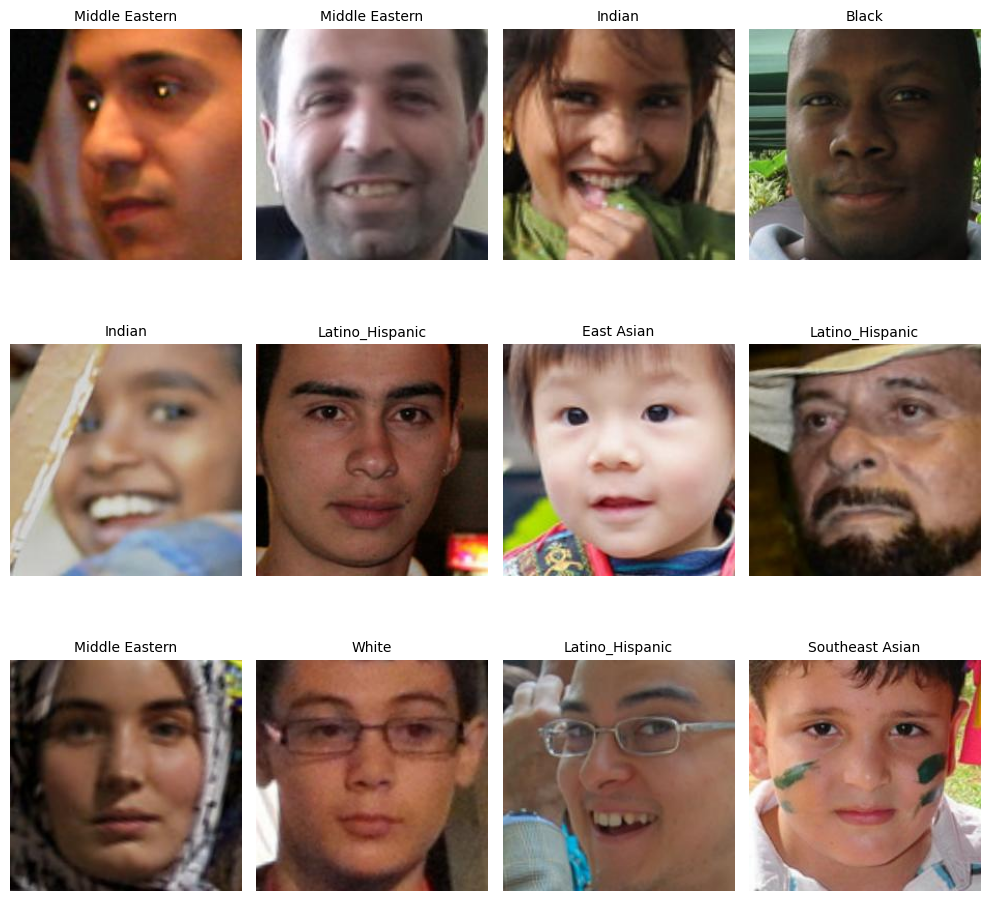

In [10]:
sample_df = train_labels.sample(12, random_state=42).reset_index(drop=True)

plt.figure(figsize=(10, 10))

for i in range(12):
    img_path = sample_df.loc[i, 'file']
    label = sample_df.loc[i, 'race']
    
    img = Image.open(img_path)
    
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

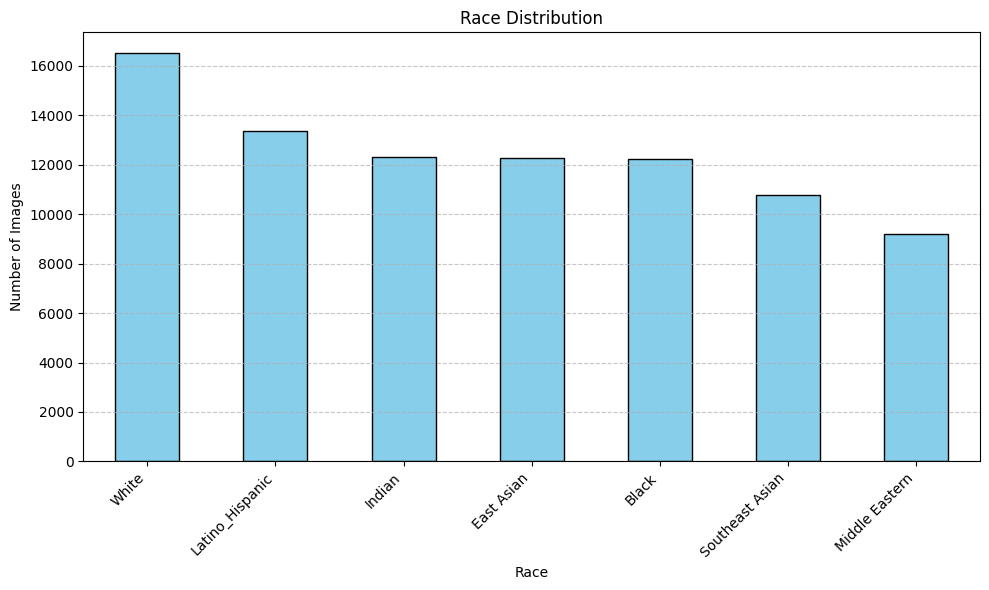

In [11]:
race_counts = train_labels['race'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
race_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Preprocessing

In [31]:
class RaceDataset(Dataset):
    def __init__(self, labels_df, transform=None):
        self.labels_df = labels_df.reset_index(drop=True)
        self.transform = transform
        self.label_to_index = {
            label: idx for idx, label in enumerate(sorted(labels_df['race'].unique()))
        }

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        image_path = row['file']
        label = self.label_to_index[row['race']]

        image = Image.open(image_path).convert("RGB")  # safer than OpenCV

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.labels_df)

In [32]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [33]:
train_dataset = RaceDataset(train_labels, transform=transform)
val_dataset = RaceDataset(val_labels, transform=transform)

In [34]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [35]:
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(val_dataset))

Number of training images: 86744
Number of validation images: 10954


In [36]:
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))

Number of training batches: 2711
Number of validation batches: 343


## Modelling

In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(14 * 14 * 256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [49]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [50]:
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [51]:
num_epochs = 10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc) 

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10 - Train Loss: 1.0438, Train Acc: 0.6007 | Val Loss: 0.8267, Val Acc: 0.6825
Epoch 2/10 - Train Loss: 0.7453, Train Acc: 0.7206 | Val Loss: 0.8197, Val Acc: 0.6914
Epoch 3/10 - Train Loss: 0.5676, Train Acc: 0.7898 | Val Loss: 0.8318, Val Acc: 0.7028
Epoch 4/10 - Train Loss: 0.4035, Train Acc: 0.8503 | Val Loss: 0.9578, Val Acc: 0.6922
Epoch 5/10 - Train Loss: 0.2830, Train Acc: 0.8958 | Val Loss: 1.0501, Val Acc: 0.6944
Epoch 6/10 - Train Loss: 0.2113, Train Acc: 0.9234 | Val Loss: 1.2113, Val Acc: 0.6864
Epoch 7/10 - Train Loss: 0.1721, Train Acc: 0.9375 | Val Loss: 1.2661, Val Acc: 0.6854
Epoch 8/10 - Train Loss: 0.1460, Train Acc: 0.9487 | Val Loss: 1.3679, Val Acc: 0.6798
Epoch 9/10 - Train Loss: 0.1286, Train Acc: 0.9539 | Val Loss: 1.3191, Val Acc: 0.6827
Epoch 10/10 - Train Loss: 0.1178, Train Acc: 0.9582 | Val Loss: 1.3761, Val Acc: 0.6857


## Evaluation

In [52]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [53]:
val_preds, val_targets = get_predictions(model, val_loader)

accuracy = accuracy_score(val_targets, val_preds)
precision = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
recall = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Accuracy : 0.6857
Precision: 0.6849
Recall   : 0.6857
F1 Score : 0.6848


<Figure size 800x800 with 0 Axes>

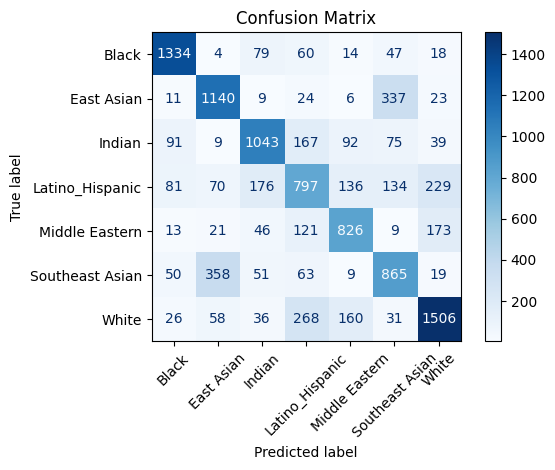

In [54]:
class_names = list(train_dataset.label_to_index.keys())

cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

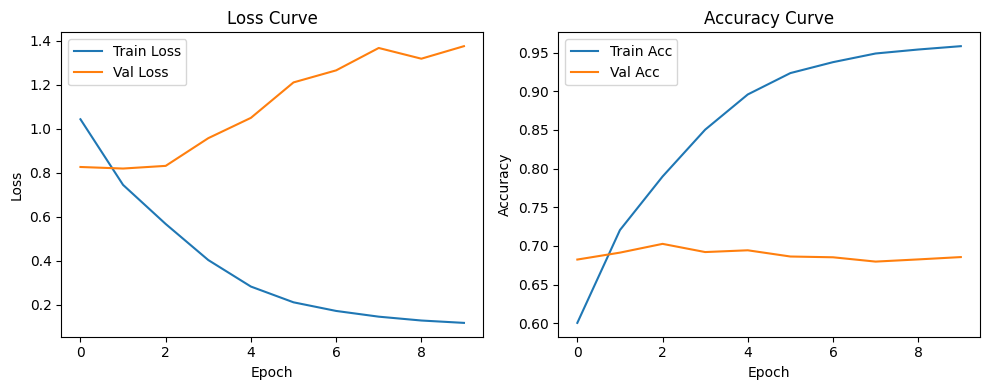

In [55]:
# Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)
plt.show()